In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# "sigmoid cross entropy with logits" in lab material
from torch.nn.functional import binary_cross_entropy_with_logits as bincre_wlogits

import torchvision
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available()
                      else "cpu")
torch.manual_seed(1)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

In [ ]:
# Random sample
def sample_Z(m, n):
    return torch.randn(m, n)

# Re-implement 
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / (in_dim / 2.)**0.5  # Using standard Python sqrt calculation
    return torch.randn(*size) * xavier_stddev

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.W1 = nn.Parameter(xavier_init([784, 128]))
        self.b1 = nn.Parameter(torch.zeros(128))
        self.W2 = nn.Parameter(xavier_init([128, 1]))
        self.b2 = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        x = torch.relu(x @ self.W1 + self.b1)
        logits = x @ self.W2 + self.b2
        prob = torch.sigmoid(logits)
        return prob, logits


class Generator(nn.Module):
    def __init__(self, zdim):
        super(Generator, self).__init__()
        self.W1 = nn.Parameter(xavier_init([zdim, 128]))
        self.b1 = nn.Parameter(torch.zeros(128))
        self.W2 = nn.Parameter(xavier_init([128, 784]))
        self.b2 = nn.Parameter(torch.zeros(784))

    def forward(self, z):
        z = torch.relu(z @ self.W1 + self.b1)
        log_prob = z @ self.W2 + self.b2
        prob = torch.sigmoid(log_prob)
        return prob

m: 50, k: 1, zdim: 100
Iteration 0: D_loss 2.2513504028320312, G_loss 1.8192355632781982


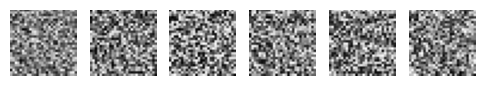

Iteration 400: D_loss 2.277399778366089, G_loss 1.868374228477478


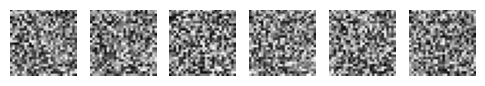

Iteration 800: D_loss 2.2088773250579834, G_loss 1.828912615776062


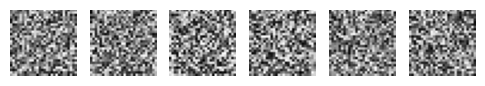

Iteration 1200: D_loss 2.2544710636138916, G_loss 1.8698179721832275


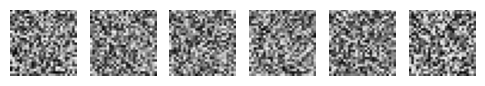

Iteration 1600: D_loss 2.2111730575561523, G_loss 1.810874342918396


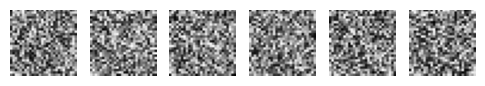

Final: D_loss 2.1967852115631104, G_loss 1.8026368618011475


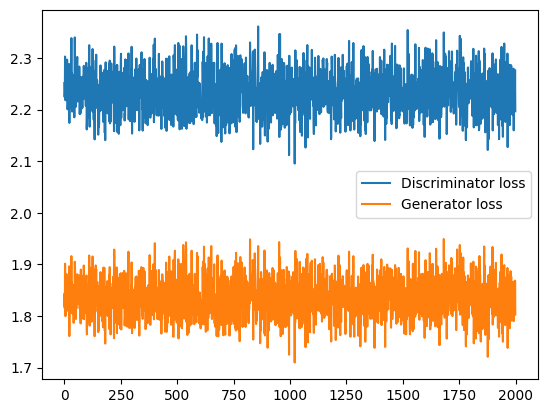

In [66]:
m = 50
k = 1
zdim = 100

def train(iterations, loss_criterion="", no_printouts=5, no_samples=6):
    generator = Generator(zdim=zdim)
    discriminator = Discriminator()
    D_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=0.001)
    G_optimizer = torch.optim.Adam(params=generator.parameters(), lr=0.001)
    train_loader = DataLoader(train_set, batch_size=m, shuffle=True)

    d_history = []
    g_history = []

    print(f"m: {m}, k: {k}, zdim: {zdim}")
    if  k > 1: "note: history records last iteration in discriminator"
    if loss_criterion == "logistic":
        print("Running with logistic loss")
    
    for it in range(iterations):
        
        # Update discriminator (k times)
        for jt in range(k):  
            (batch_images, batch_label)  = next(iter(train_loader))
            batch_images = batch_images.view(batch_images.size(0), -1)  # Flatten the image tensor if needed
            Z = sample_Z(m, zdim)  # Sample noise

            D_optimizer.zero_grad()
            x = generator(Z)
            D_real, D_logit_real = discriminator(batch_images)
            D_fake, D_logit_fake = discriminator(x)    
            D_optimizer.step()

            if loss_criterion == "logistic":
                D_loss_real = torch.mean(bincre_wlogits(D_logit_real, torch.ones_like(D_real)))
                D_loss_fake = torch.mean(bincre_wlogits(D_logit_fake, torch.ones_like(D_fake)))
                D_loss = D_loss_real + D_loss_fake
            else:
                D_loss = -torch.mean(torch.log(D_real) + torch.log(torch.ones(D_fake.shape) - D_fake))


        # Update generator
        Z = sample_Z(m, zdim)  # Sample noise
        G_optimizer.zero_grad()
        G_img_fake = generator(Z)
        G_fake, G_logit_fake = discriminator(G_img_fake)
        G_optimizer.step()

        if loss_criterion == "logistic":
            G_loss = torch.mean(bincre_wlogits(G_logit_fake, torch.ones_like(G_fake)))
        else:
            G_loss = -torch.mean(torch.log(1 - D_fake))

        
        # Printouts + history
        d_history.append(D_loss.item())
        g_history.append(G_loss.item())
        if it % (iterations/no_printouts) == 0:
            print(f"Iteration {it}: D_loss {D_loss.item()}, G_loss {G_loss.item()}")
            r = m if m < no_samples else no_samples
            fig, axes = plt.subplots(1, r, figsize=(r, 1), sharex=True, sharey=True)
            for ri in range(r):
                G_img = G_img_fake[ri].detach()
                G_img = torch.reshape(G_img, [28,28])
                axes[ri].imshow(G_img, cmap='gray')
                axes[ri].axis('off')
            plt.show()

    print(f"Final: D_loss {D_loss.item()}, G_loss {G_loss.item()}")
    plt.plot(d_history, label="Discriminator loss")
    plt.plot(g_history, label="Generator loss")
    plt.legend()
    plt.show()

    return discriminator, generator

In [ ]:
# 2.1: Train with std loss
D11, G11 = train(iterations=20_000)
D12, G12 = train(iterations=100_000)

In [ ]:
# 2.2: Train with logistic loss
D21, G21 = train(iterations=20_000, loss_criterion="logistic")
D22, G22 = train(iterations=100_000, loss_criterion="logistic")

In [ ]:
# 2.3

In [ ]:
# 2.4

In [ ]:
# 2.5